# RADTorch Playground

This notebook provides a step by step tutorial on examples using RADTorch Pipelines

## Install RADTorch

In [0]:
## install latest nightly release
!pip3 install https://repo.radtorch.com/archive/v0.1.2-beta-2.zip -q




     - 3.6MB 42.0MB/s
     |████████████████████████████████| 35.3MB 88kB/s 


## Import Demo Data


In this tutorial We will use the chest xray data provided by Daniel Kermany, Kang Zhang, Michael Goldbaum

Dataset: Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification

File: ChestXRay2017

File Size: 1.2 GB

DOI: http://dx.doi.org/10.17632/rscbjbr9sj.2#file-41d542e7-7f91-47f6-9ff2-dd8e5a5a7861

In [0]:
!rm -r /content/sample_data/
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip -q
!unzip -q /content/ChestXRay2017.zip
!find . -name "*.DS_Store" -type f -delete

## Image Classification Pipeline

In this tutorial, we will create a simple image classification pipeline to classify normal vs pneumonia from our dataset.

To make the classification problem more interesting, we will divide the dataset further into normal, bacterial pneumonia and viral pneumonia using keywords in file names.


In [0]:
from radtorch import datautils, pipeline
import pandas as pd

In [0]:
#Creating list of files for each class
pneumonia_file_list = datautils.list_of_files('/content/chest_xray/train/PNEUMONIA/')
bacterial_list = [i for i in pneumonia_file_list if 'bacteria' in i]
viral_list = [i for i in pneumonia_file_list if 'virus' in i]
normal_list = datautils.list_of_files('/content/chest_xray/train/NORMAL/')

#For demo we will use only 400 of each class.
subset = 400

#Create Dataframe of image paths and image labels.
data_sub = bacterial_list[:subset]+viral_list[:subset]+normal_list[:subset]
label_sub = ['bacteria']*subset+['virus']*subset+['normal']*subset

data_label_df = pd.DataFrame(list(zip(data_sub, label_sub)), columns=['IMAGE_PATH', 'IMAGE_LABEL'])
data_label_df = data_label_df.sample(frac=1).reset_index(drop=True) #shuffle dataset
data_label_df.head()

IMAGE_PATH IMAGE_LABEL
0  /content/chest_xray/train/PNEUMONIA/person1790...    bacteria
1  /content/chest_xray/train/PNEUMONIA/person498_...    bacteria
2  /content/chest_xray/train/NORMAL/IM-0274-0001....      normal
3  /content/chest_xray/train/NORMAL/IM-0606-0001....      normal
4  /content/chest_xray/train/NORMAL/NORMAL2-IM-05...      normal

In [0]:
#Create the image classification pipeline object
clf = pipeline.Image_Classification(data_directory='/content/chest_xray/train/',
                                    model_arch='resnet152', 
                                    is_dicom=False, 
                                    label_from_table=True, 
                                    table_source=data_label_df, 
                                    valid_percent=0.2, 
                                    test_percent=0.2, train_epochs=10)

In [0]:
#Display dataset information
clf.dataset_info()

Classes Class Idx  Number of Instances
0            bacteria         0                  400
1              normal         1                  400
2               virus         2                  400
3     Total Instances                           1200
4  Train Dataset Size                            720
5  Valid Dataset Size                            240
6   Test Dataset Size                            240

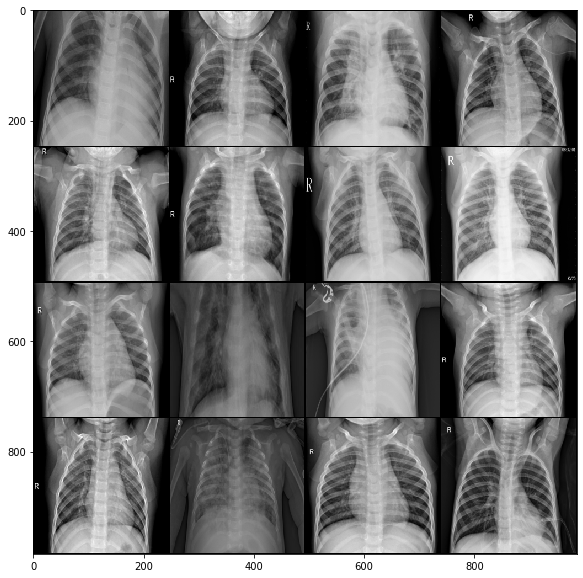

In [0]:
#Display sample images from dataset
clf.sample()

In [0]:
#Train Image Classification Pipeline
clf.train()

Starting training at 2020-03-09 03:01:55.661412


Epoch : 000/10 : [Training: Loss: 0.5971, Accuracy: 72.5000%]  [Validation : Loss : 0.6712, Accuracy: 71.6667%] [Time: 71.2096s]
Epoch : 001/10 : [Training: Loss: 0.2990, Accuracy: 88.7500%]  [Validation : Loss : 0.4865, Accuracy: 78.3333%] [Time: 71.3546s]
Epoch : 002/10 : [Training: Loss: 0.1976, Accuracy: 93.6111%]  [Validation : Loss : 0.7025, Accuracy: 79.1667%] [Time: 71.2479s]
Epoch : 003/10 : [Training: Loss: 0.0974, Accuracy: 96.6667%]  [Validation : Loss : 0.8476, Accuracy: 74.5833%] [Time: 71.4931s]
Epoch : 004/10 : [Training: Loss: 0.1091, Accuracy: 96.3889%]  [Validation : Loss : 0.8745, Accuracy: 80.0000%] [Time: 71.2629s]
Epoch : 005/10 : [Training: Loss: 0.1010, Accuracy: 97.0833%]  [Validation : Loss : 0.6462, Accuracy: 77.5000%] [Time: 71.5712s]
Epoch : 006/10 : [Training: Loss: 0.0580, Accuracy: 98.3333%]  [Validation : Loss : 0.6558, Accuracy: 81.2500%] [Time: 72.1854s]
Epoch : 007/10 : [Training: Loss: 0.0542, Accuracy: 98.6111%]  [Validation : Loss : 0.7984, Accur

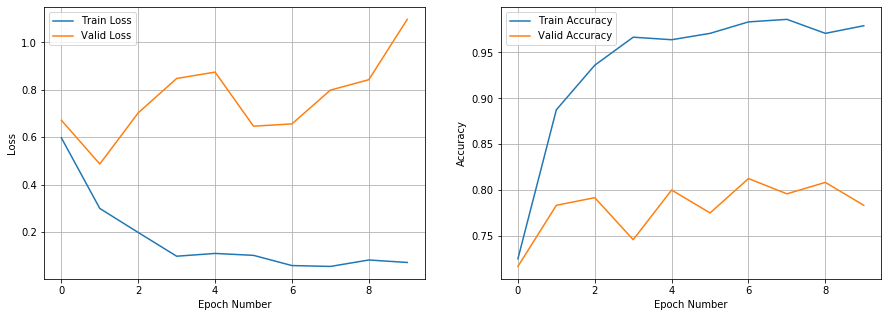

In [0]:
clf.metrics()

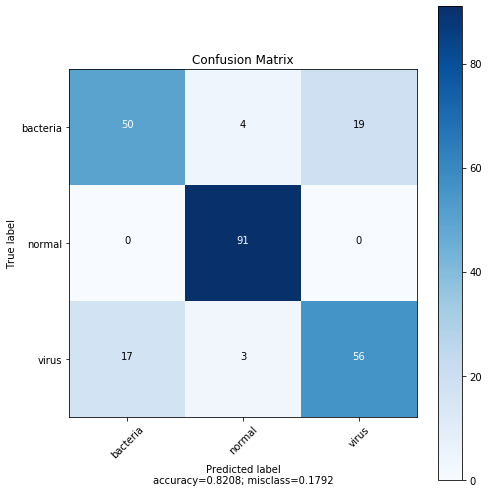

In [0]:
clf.confusion_matrix()

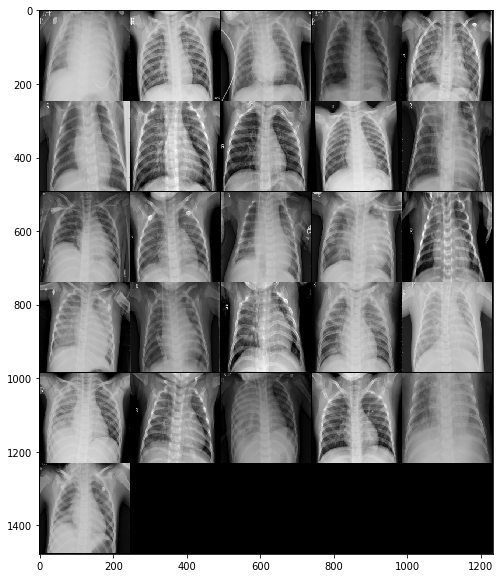

In [0]:
X = clf.misclassified(num_of_images=25, figure_size=(10,10))

In [0]:
clf.misclassified_instances.head()

image_path  ...  predicted_label
0  /content/chest_xray/train/PNEUMONIA/person12_b...  ...                1
1  /content/chest_xray/train/PNEUMONIA/person1308...  ...                2
2  /content/chest_xray/train/PNEUMONIA/person1176...  ...                0
3  /content/chest_xray/train/PNEUMONIA/person820_...  ...                0
4  /content/chest_xray/train/PNEUMONIA/person309_...  ...                0

[5 rows x 3 columns]

In [0]:
clf.export_model('/content/trained_model.pth')

Trained classifier exported successfully.


## Feature Extraction Pipeline

In this tutorial, we will create an feature extraction pipeline. 

We'll use a native ResNet152 model trained on ImageNet dataset and extract the features from our a new dataset (in the test folder).


In [0]:
from radtorch import pipeline, datautils
import pandas as pd

In [0]:
#Creating list of files for each class
pneumonia_file_list = datautils.list_of_files('/content/chest_xray/test/PNEUMONIA/')
bacterial_list = [i for i in pneumonia_file_list if 'bacteria' in i]
viral_list = [i for i in pneumonia_file_list if 'virus' in i]
normal_list = datautils.list_of_files('/content/chest_xray/test/NORMAL/')

#Create Dataframe of image paths and image labels.
data_sub = bacterial_list+viral_list+normal_list
label_sub = ['bacteria']*len(bacterial_list)+['virus']*len(viral_list)+['normal']*len(normal_list)

data_label_df = pd.DataFrame(list(zip(data_sub, label_sub)), columns=['IMAGE_PATH', 'IMAGE_LABEL'])
data_label_df = data_label_df.sample(frac=1).reset_index(drop=True) #shuffle dataset
data_label_df.head()

IMAGE_PATH IMAGE_LABEL
0  /content/chest_xray/test/PNEUMONIA/person10_vi...       virus
1  /content/chest_xray/test/NORMAL/NORMAL2-IM-010...      normal
2  /content/chest_xray/test/PNEUMONIA/person100_b...    bacteria
3  /content/chest_xray/test/PNEUMONIA/person64_vi...       virus
4  /content/chest_xray/test/PNEUMONIA/person175_b...    bacteria

In [0]:
#Create Feature Extraction Pipeline
ext = pipeline.Feature_Extraction(data_directory='/content/chest_xray/test/',
                                  is_dicom=False, 
                                  model_arch='resnet152', 
                                  label_from_table=True, 
                                  table_source=data_label_df)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [0]:
ext.dataset_info()

Classes Class Idx  Number of Instances
0         bacteria         0                  242
1           normal         1                  234
2            virus         2                  148
3  Total Instances                            624

labels: tensor([0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0])


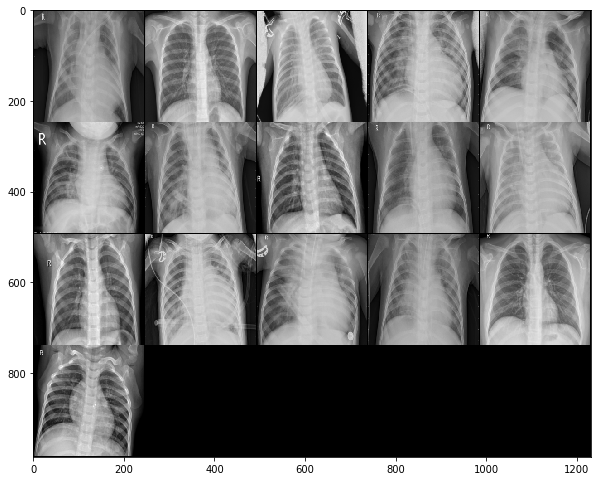

In [0]:
#Display Sample images
ext.sample()

In [0]:
#Display class to idx mapping
ext.data_set.class_to_idx

{'bacteria': 0, 'normal': 1, 'virus': 2}

In [0]:
# Display number of features that will be extracted (model architecture dependent)
ext.num_features()

2048

In [0]:
#Run Feature Extraction Pipeline
ext.run(verbose=False)


 Features extracted successfully.


In [0]:
#Display features generated
ext.feature_table

img_path  ...    f_2047
0    /content/chest_xray/test/PNEUMONIA/person91_ba...  ...  0.511106
1    /content/chest_xray/test/PNEUMONIA/person16_vi...  ...  0.070846
2    /content/chest_xray/test/NORMAL/NORMAL2-IM-031...  ...  0.543611
3    /content/chest_xray/test/NORMAL/IM-0039-0001.jpeg  ...  0.282701
4    /content/chest_xray/test/NORMAL/NORMAL2-IM-034...  ...  0.390644
..                                                 ...  ...       ...
619  /content/chest_xray/test/PNEUMONIA/person1662_...  ...  0.688763
620  /content/chest_xray/test/NORMAL/NORMAL2-IM-022...  ...  0.199747
621  /content/chest_xray/test/PNEUMONIA/person103_b...  ...  0.198905
622  /content/chest_xray/test/PNEUMONIA/person1633_...  ...  0.518185
623  /content/chest_xray/test/PNEUMONIA/person46_vi...  ...  0.577861

[624 rows x 2050 columns]

In [0]:
# Plot the extracted features per each class
ext.plot_extracted_features(num_features=200)

In [0]:
#Export Generated Features
ext.export_features('/content/features.csv')

Features exported to CSV successfully.
